In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = { s: i+1 for i, s in enumerate(chars) }
stoi['.'] = 0
itos = { i: s for s, i in stoi.items()}

In [5]:
block_size = 3
X, Y = [], []
context = [0] * block_size
for w in words:
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [7]:
def build_dataset(words):
  block_size = 3
  X, Y = [], []
  context = [0] * block_size
  for w in words:
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]
  
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

print(Xtr.shape, Ytr.shape)
print(Xdev.shape, Ydev.shape)
print(Xte.shape, Yte.shape)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


word: cat, blocksize: 3
---

x: ... \
y: c

x: ..c \
y: a

x: .ca \
y: t

x: cat \
y: .

In [8]:
C = torch.randn((27, 2))

In [9]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [10]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [11]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [12]:
h

tensor([[ 0.8442,  0.5336, -0.4575,  ...,  0.5174,  0.4990,  0.9728],
        [ 0.6343,  0.6854, -0.8861,  ...,  0.2315,  0.0801,  0.9881],
        [-0.1682,  0.2153,  0.9416,  ...,  0.9976, -0.2517,  0.9879],
        ...,
        [ 0.9999, -0.9327,  0.9744,  ...,  0.6412, -0.8556,  0.7852],
        [ 1.0000, -0.9968, -0.8907,  ...,  0.9917,  0.9908,  0.9998],
        [ 0.9980, -0.9475, -0.9975,  ..., -0.9362, -0.9992,  0.9972]])

In [13]:
h.shape

torch.Size([228146, 100])

In [14]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [15]:
logits = h @ W2 + b2

In [16]:
logits.shape

torch.Size([228146, 27])

In [17]:
counts = logits.exp()

In [18]:
prob = counts / counts.sum(1, keepdim=True)

In [19]:
prob.shape

torch.Size([228146, 27])

In [20]:
prob[0].sum()

tensor(1.0000)

In [21]:
loss = -prob[torch.arange(X.shape[0]), Y].log().mean()
loss

tensor(19.0124)

In [22]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [23]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [24]:
sum(p.nelement() for p in parameters)

11897

In [25]:
for p in parameters:
  p.requires_grad = True

In [26]:
lre = torch.linspace(-3, 0, 200000)
lrs = 10**lre

In [27]:
lri = []
lossi = []
stepi = []

for i in range(200000):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,)) # (32)

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = lrs[i]
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  lossi.append(loss.log10().item())
  stepi.append(i)

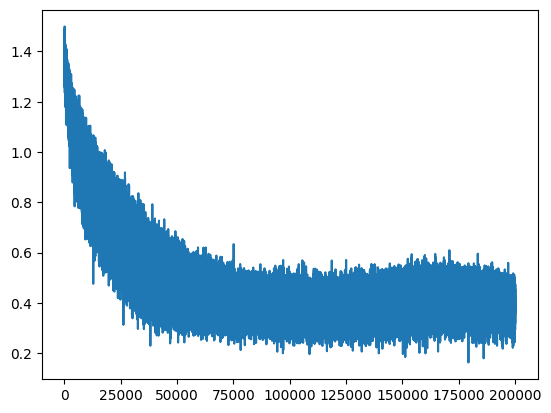

In [28]:
plt.plot(stepi, lossi)

In [29]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.4355, grad_fn=<NllLossBackward0>)

In [30]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.4422, grad_fn=<NllLossBackward0>)

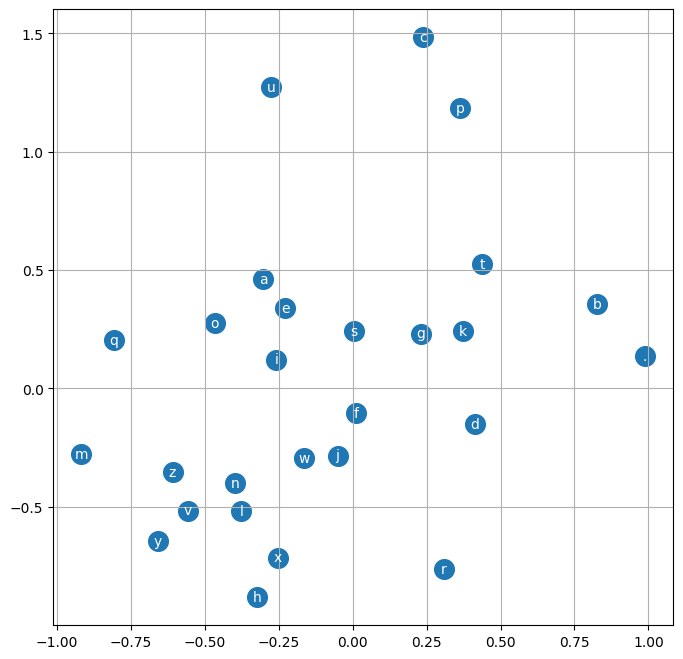

In [31]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [48]:
context = [0] * block_size
emb = C[torch.tensor([context])]
emb.shape

torch.Size([1, 3, 10])

In [51]:
(emb.view(1, -1) @ W1 + b1).shape

torch.Size([1, 200])

In [54]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    # forward pass
    emb = C[torch.tensor([context])] # (1, 3, 10)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1) # (1, 200)
    logits = h @ W2 + b2 # (1, 27)
    probs = F.softmax(logits, dim=1) # (1, 27)
    ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    context = context[1:] + [ix]
    if ix == 0:
      break
  print(''.join(out))

caralixan.
rim.
rakimri.
rey.
lahnanden.
jakhithadpeyaha.
areli.
arlani.
rceniiv.
asleyn.
dham.
foi.
dquinn.
arli.
ray.
adbi.
wantha.
dearixi.
fimeriighan.
eddedi.
